In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev_L3

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_LU, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

import uqtestfuns as uqtf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

/home/ashish-razer/Programs/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
my_testfun =  uqtf.Borehole()
print(my_testfun)

Name              : Borehole
Spatial dimension : 8
Description       : Borehole function from Harper and Gupta (1983)


In [3]:
my_testfun.prob_input

No.,Name,Distribution,Parameters,Description
1,rw,normal,[0.1 0.0161812],radius of the borehole [m]
2,r,lognormal,[7.71 1.0056],radius of influence [m]
3,Tu,uniform,[ 63070. 115600.],transmissivity of upper aquifer [m^2/year]
4,Hu,uniform,[ 990. 1100.],potentiometric head of upper aquifer [m]
5,Tl,uniform,[ 63.1 116. ],transmissivity of lower aquifer [m^2/year]
6,Hl,uniform,[700. 820.],potentiometric head of lower aquifer [m]
7,L,uniform,[1120. 1680.],length of the borehole [m]
8,Kw,uniform,[ 9985. 12045.],hydraulic conductivity of the borehole [m/year]


In [4]:
xx = np.array([
  [
    1.04803586e-01, 2.54527756e+03, 9.44572869e+04, 9.94988176e+02,
    6.31793993e+01, 7.63308791e+02, 1.57530252e+03, 1.00591588e+04
  ]
])
my_testfun(xx)

array([50.7642835])

In [5]:
N = 10000
np.random.seed(42)
xx_sample_dom_1 = -1 + 2 * np.random.rand(N, 8)
xx_sample = my_testfun.transform_sample(xx_sample_dom_1)
#xx_sample = my_testfun.prob_input.get_sample(N)
target_scaler = MinMaxScaler()

yy_sample = my_testfun(xx_sample)
target_scaler.fit(yy_sample.reshape(-1,1))
yy_sample = target_scaler.transform(yy_sample.reshape(-1,1))

In [6]:
inverse = target_scaler.inverse_transform(yy_sample)


In [7]:
#yy_sample.reshape(1,-1).shape

In [8]:
_, IN_DIM = xx_sample.shape
input_tensor  = torch.tensor(xx_sample_dom_1, dtype=torch.float32)
target =  torch.tensor(yy_sample, dtype=torch.float32)
dataset = torch.cat((input_tensor, target), 1)

In [9]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
NUM_EPOCHS = 5
RANK = 10
LHP = 20
OUT_DIM = 1
DEGREE = 3
loss_fn = nn.MSELoss()

In [10]:
model = CP(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
model = Chebyshev(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
"""model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
).to(device)"""
#NCP_poly = NCP_L3(IN_DIM, RANK, OUT_DIM, LHP).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
train_loader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

In [12]:
list_of_losses = []
list_of_epochs = []

for epoch in range(NUM_EPOCHS):
    for batch in train_loader:   
        #output = canonical_poly(input_tensor.to(device))
        output = model(batch[:,:8].to(device))
        loss = loss_fn(output.to(device), batch[:,8:].to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(1)

    list_of_losses.append(loss)
    list_of_epochs.append(epoch + 1)
    print('loss', loss)
    print("Epoch : ", epoch + 1)

loss tensor(0.0490, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  1
loss tensor(0.0353, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  2
loss tensor(0.0385, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  3
loss tensor(0.0469, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  4
loss tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  5


In [13]:
model.to('cpu')

Chebyshev(
  (T1): Linear(in_features=8, out_features=10, bias=False)
  (T2): Linear(in_features=8, out_features=10, bias=False)
  (T3): Linear(in_features=8, out_features=10, bias=False)
  (layer_C): Linear(in_features=10, out_features=1, bias=True)
)

In [14]:
num_param = []
for name, param in model.named_parameters():
    num = torch.count_nonzero(param)
    num_param.append(num)

before = torch.sum(torch.tensor(num_param))

In [15]:
before

tensor(261)

In [16]:
outputs1 = model(input_tensor.to('cpu')).to('cpu').detach().numpy()

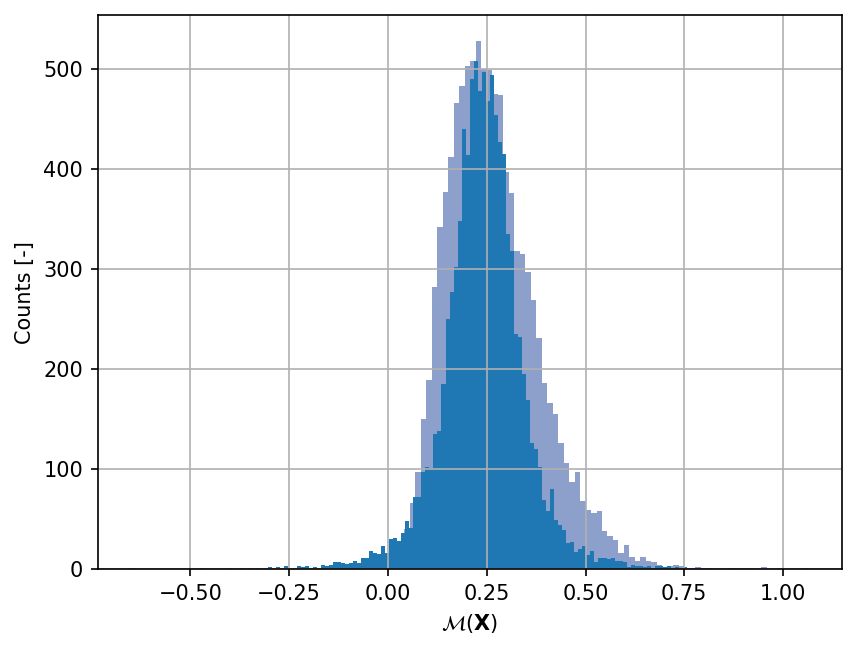

In [17]:
import matplotlib.pyplot as plt

plt.hist(yy_sample, bins="auto", color="#8da0cb")
plt.hist(outputs1, bins='auto')
plt.grid()
plt.xlabel("$\mathcal{M}(\mathbf{X})$")
plt.ylabel("Counts [-]")
plt.gcf().set_dpi(150);

In [18]:
state_dict = model.state_dict()
for name, p in model.named_parameters():
    print(state_dict[name])
    mask1 = p > 0.1 
    mask2 = p < -0.1
    mask3 =  (mask1 | mask2) 
    p = nn.Parameter(mask3 * p)
    state_dict[name] = p
    print(state_dict[name])

model.load_state_dict(state_dict)

tensor([-0.1681, -0.1831, -0.2649,  0.2397,  0.2784, -0.1982, -0.0231, -0.2752,
         0.1648, -0.1681])
Parameter containing:
tensor([-0.1681, -0.1831, -0.2649,  0.2397,  0.2784, -0.1982, -0.0000, -0.2752,
         0.1648, -0.1681], requires_grad=True)
tensor([[ 0.3013, -0.2984, -0.1071,  0.2355,  0.1434, -0.1974, -0.0383,  0.1938],
        [-0.2554, -0.2733,  0.2589,  0.2854,  0.0395, -0.2603, -0.1357,  0.0570],
        [-0.4391, -0.1167,  0.3081,  0.2235, -0.3743, -0.0897,  0.3044,  0.0304],
        [ 0.0089,  0.0794, -0.2836,  0.2598,  0.1625, -0.2838,  0.3312,  0.2005],
        [-0.1152, -0.2194,  0.2123,  0.0714,  0.3672, -0.3091, -0.2791,  0.0957],
        [ 0.1430, -0.3211, -0.3925,  0.3216, -0.2775,  0.1282,  0.2250, -0.2203],
        [-0.3354, -0.1164, -0.0690, -0.3605,  0.0652, -0.0378,  0.2035,  0.1111],
        [ 0.1975,  0.2503,  0.2023,  0.2287, -0.2466,  0.1503,  0.1486, -0.0475],
        [ 0.2467,  0.0749, -0.0768, -0.0467, -0.1081, -0.2026, -0.1386, -0.3080],
      

<All keys matched successfully>

In [19]:
num_param = []
for name, param in model.named_parameters():
    num = torch.count_nonzero(param)
    num_param.append(num)

after = torch.sum(torch.tensor(num_param))

In [20]:
after

tensor(181)

In [21]:
(before - after)

tensor(80)

In [22]:
def prod_multi_index(mi1, mi2):
    sum_list = []
    for i in mi2:
        tile = np.tile(i, (len(mi1),1))
        sum = mi1 + tile
        sum_list = sum_list + [sum]
        sum_array = np.vstack(tuple(sum_list))
        mi3 = np.unique(np.array(sum_array), axis=0)
    return mi3

In [ ]:
def prod_multi_index2(mi1, mi2):
    sum_list = []
    for i in mi2:
        sum = mi1 + i
        sum_list.append(sum)
    sum_array = np.vstack(tuple(sum_list))
    mi3 = np.unique(np.array(sum_array), axis=0)
    return mi3

In [23]:
def add_multi_index(mi1, mi2):
    mi3 = np.unique(np.vstack((mi1, mi2)), axis=0)
    return mi3

In [24]:
if isinstance(model, CP):
   sparse_param = []
   for name, p in model.named_parameters():  
      if len(p.shape) == 2:
         #print(p.shape)
         if p.shape[0] == RANK and p.shape[1] == IN_DIM:
            sparse_param = sparse_param + [p]
      

In [25]:
if isinstance(model, CP):
    sparse_mi = []
    for i in sparse_param:
        ind = torch.where(i[0] == 0)[0].to('cpu').detach().numpy()
        mi_w = np.eye(i.shape[1])
        mi_w_s = np.delete(mi_w, ind, 0)
        sparse_mi = sparse_mi + [mi_w_s]


In [26]:
if isinstance(model, CP):
    mi_s = sparse_mi[0]
    for i in range(1, len(sparse_mi)):
        mi1 = sparse_mi[i]
        mi_s = add_multi_index(prod_multi_index(mi_s, mi1), mi_s)

In [27]:
isinstance(model, CP)

False

In [28]:
if isinstance(model, Chebyshev):
   sparse_param = []
   for name, p in model.named_parameters():  
      if len(p.shape) == 2:
         #print(p.shape)
         if p.shape[0] == RANK and p.shape[1] == IN_DIM:
            sparse_param = sparse_param + [p]
      

In [29]:
if isinstance(model, Chebyshev):
    sparse_mi = []
    for i in sparse_param:
        ind = torch.where(i[0] == 0)[0].to('cpu').detach().numpy()
        mi_w = np.eye(i.shape[1])
        mi_w_s = np.delete(mi_w, ind, 0)
        sparse_mi = sparse_mi + [mi_w_s]


In [30]:
if isinstance(model, Chebyshev):
    mi_s = sparse_mi[0]
    for i in range(1, len(sparse_mi)):
        mi1 = sparse_mi[i]
        mi_s = add_multi_index(prod_multi_index(mi_s, mi1), mi_s)

In [31]:
if isinstance(model, Chebyshev):
    mi_s1 = sparse_mi[0]
    for i in range(1, len(sparse_mi)):
        mi1 = sparse_mi[i]
        mi_s = add_multi_index(prod_multi_index(mi_s, mi1), mi_s)

In [32]:
outputs2 = model(input_tensor.to('cpu')).to('cpu').detach().numpy()

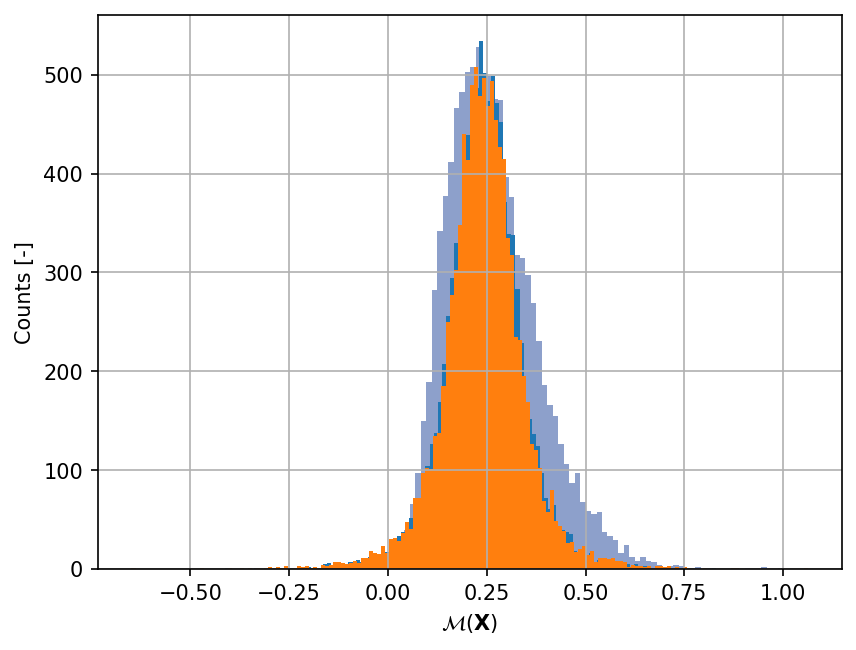

In [33]:
import matplotlib.pyplot as plt

plt.hist(yy_sample, bins="auto", color="#8da0cb")
plt.hist(outputs2, bins='auto')
plt.hist(outputs1, bins='auto')
plt.grid()
plt.xlabel("$\mathcal{M}(\mathbf{X})$")
plt.ylabel("Counts [-]")
plt.gcf().set_dpi(150);

In [34]:
out1_inv = target_scaler.inverse_transform(outputs1) 
out2_inv = target_scaler.inverse_transform(outputs2) 

In [35]:
average_error = np.mean(out1_inv - out2_inv)

In [36]:
average_error

-0.21941324

In [37]:
np.mean(target_scaler.inverse_transform(yy_sample))

72.94882935911545

In [38]:
mse = ((out1_inv - out2_inv)**2).mean(axis = 0)

In [39]:
mse

array([108.29335], dtype=float32)

In [40]:
model.to(device)

Chebyshev(
  (T1): Linear(in_features=8, out_features=10, bias=False)
  (T2): Linear(in_features=8, out_features=10, bias=False)
  (T3): Linear(in_features=8, out_features=10, bias=False)
  (layer_C): Linear(in_features=10, out_features=1, bias=True)
)

https://github.com/polynomial-nets/tutorial-2022-intro-polynomial-nets/blob/master/pytorch/Minimum_example_pytorch.ipynb

In [41]:
class Chebyshev(nn.Module):
    def __init__(self, degree, d, k, o):
        super(Chebyshev, self).__init__()        
     
        self.input_dimension = d 
        self.rank = k
        self.output_dimension = o 
        self.degree = int(degree)
        self.T0 = nn.Linear(k, 1).weight.to(torch.float32)[0]
        for i in range(1, self.degree + 1):
            setattr(self, 'T{}'.format(i), nn.Linear(self.input_dimension, self.rank, bias=False)) 

        self.layer_C = nn.Linear(self.rank, self.output_dimension) 


    def forward(self, z):
        z = z.reshape(-1, self.input_dimension)
        out0 = self.T0
        out1 = self.T1(z)
        out_list = [out0] + [out1]
        for i in range(2, self.degree + 1, 2):
            print(i)
            out0 = getattr(self, 'T{}'.format(i))(z) * 2 * out1 - out0
            out_list = out_list + [out0]
            if i == self.degree:
                print(i)
                x = self.layer_C(out_list[self.degree])
                return x, out_list
            else:
                print(i + 1)
                out1 = getattr(self, 'T{}'.format(i + 1))(z) * 2 * out0 - out1
                out_list = out_list + [out1]
        x = self.layer_C(out_list[self.degree])
        return x, out_list

In [42]:
cheby =  Chebyshev(16,2,8,2)